In [1]:
from MyImports import*

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = config["data"]["train_path"]
test_path = config["data"]["test_path"]

In [3]:
with open(train_path, "r", encoding="utf-8") as file:
    tags = {
        line.strip().split()[-1]
        for line in file
        if line.strip()  # skip empty lines
    }

print(sorted(tags))

['B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow', 'O']


In [4]:
def read_conll_file(filepath):
    """
    Parses a CoNLL-formatted NER file and returns:
    - sentences: list of list of tokens
    - labels: list of list of corresponding NER tags
    """
    sentences = []
    ner_labels = []

    with open(filepath, 'r', encoding='utf-8') as f:
        tokens = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:  # save completed sentence
                    sentences.append(tokens)
                    ner_labels.append(tags)
                    tokens, tags = [], []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token = parts[0]
                    label = parts[-1]  # assuming last column is the NER tag
                    tokens.append(token)
                    tags.append(label)
        # handle last sentence if file doesn't end with a newline
        if tokens:
            sentences.append(tokens)
            ner_labels.append(tags)

    return sentences, ner_labels
sentences, ner_labels = read_conll_file(train_path)
len(sentences), len(ner_labels)

(2394, 2394)

In [5]:
# Count frequency
ner_label_counts = Counter(list(itertools.chain.from_iterable(ner_labels)))

# Print counts
for tag, count in ner_label_counts.items():
    print(f"{tag}: {count}")

O: 44007
B-geo-loc: 276
B-facility: 104
I-facility: 105
B-movie: 34
I-movie: 46
B-company: 171
B-product: 97
B-person: 449
B-other: 225
I-other: 320
B-sportsteam: 51
I-sportsteam: 23
I-product: 80
I-company: 36
I-person: 215
I-geo-loc: 49
B-tvshow: 34
B-musicartist: 55
I-musicartist: 61
I-tvshow: 31


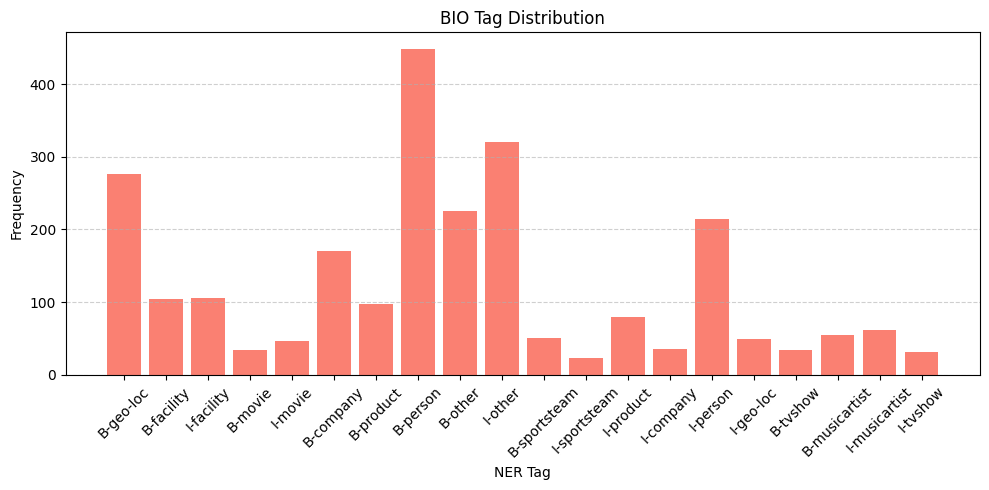

In [6]:
ner_label_counts.pop('O')
plt.figure(figsize=(10, 5))
plt.bar(ner_label_counts.keys(), ner_label_counts.values(), color='salmon')
plt.title("BIO Tag Distribution")
plt.xlabel("NER Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

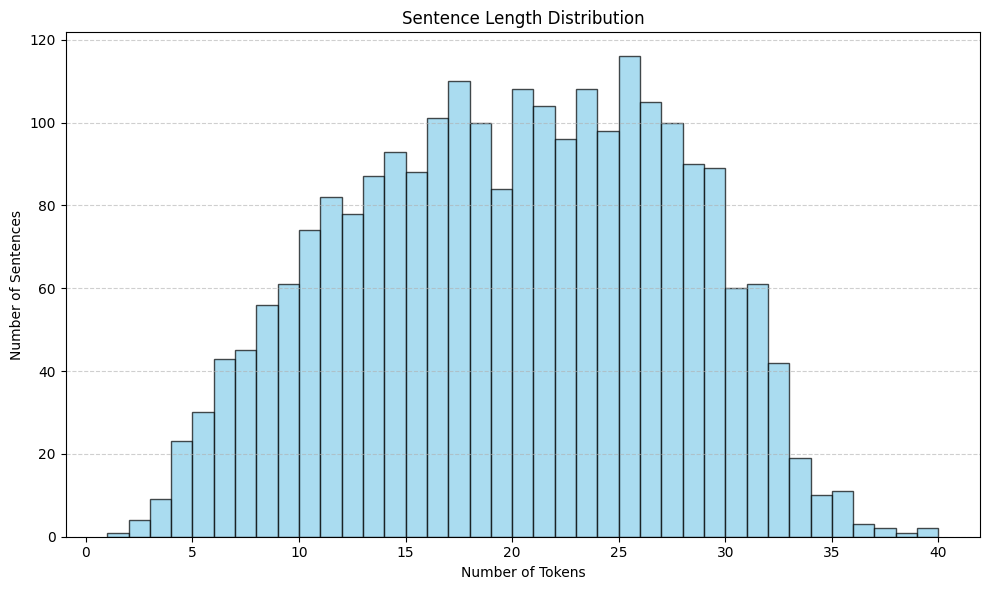

In [7]:
#Compute sentence lengths
sentence_lengths = [len(sentence) for sentence in sentences]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths)+2), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Sentences")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
print(f"Total sentences: {len(sentence_lengths)}")
print(f"Min length: {np.min(sentence_lengths)}")
print(f"Max length: {np.max(sentence_lengths)}")
print(f"Average length: {np.mean(sentence_lengths):.2f}")
print(f"Median length: {np.median(sentence_lengths)}")

Total sentences: 2394
Min length: 1
Max length: 39
Average length: 19.41
Median length: 20.0


In [9]:
entity_tokens = {
    'company':[],
    'facility':[],
    'geo-loc':[],
    'movie':[],
    'musicartist': [],
    'other':[],
    'person':[],
    'product':[],
    'sportsteam':[],
    'tvshow':[]
}

for sentence_tokens, sentence_tags in zip(sentences, ner_labels):
  for token, tag in zip(sentence_tokens, sentence_tags):
    #tag starts with B
    if tag.startswith('B-') or tag.startswith('I-'):
      # Extract the entity type (e.g., "B-person" -> "person")
      #entity_type = tag.split("-")[-1]
      entity_type =tag[2:]
      #Filter out non-alphabetic tokens and lowercase
      if token.isalpha():
        entity_tokens[entity_type].append(token.lower())


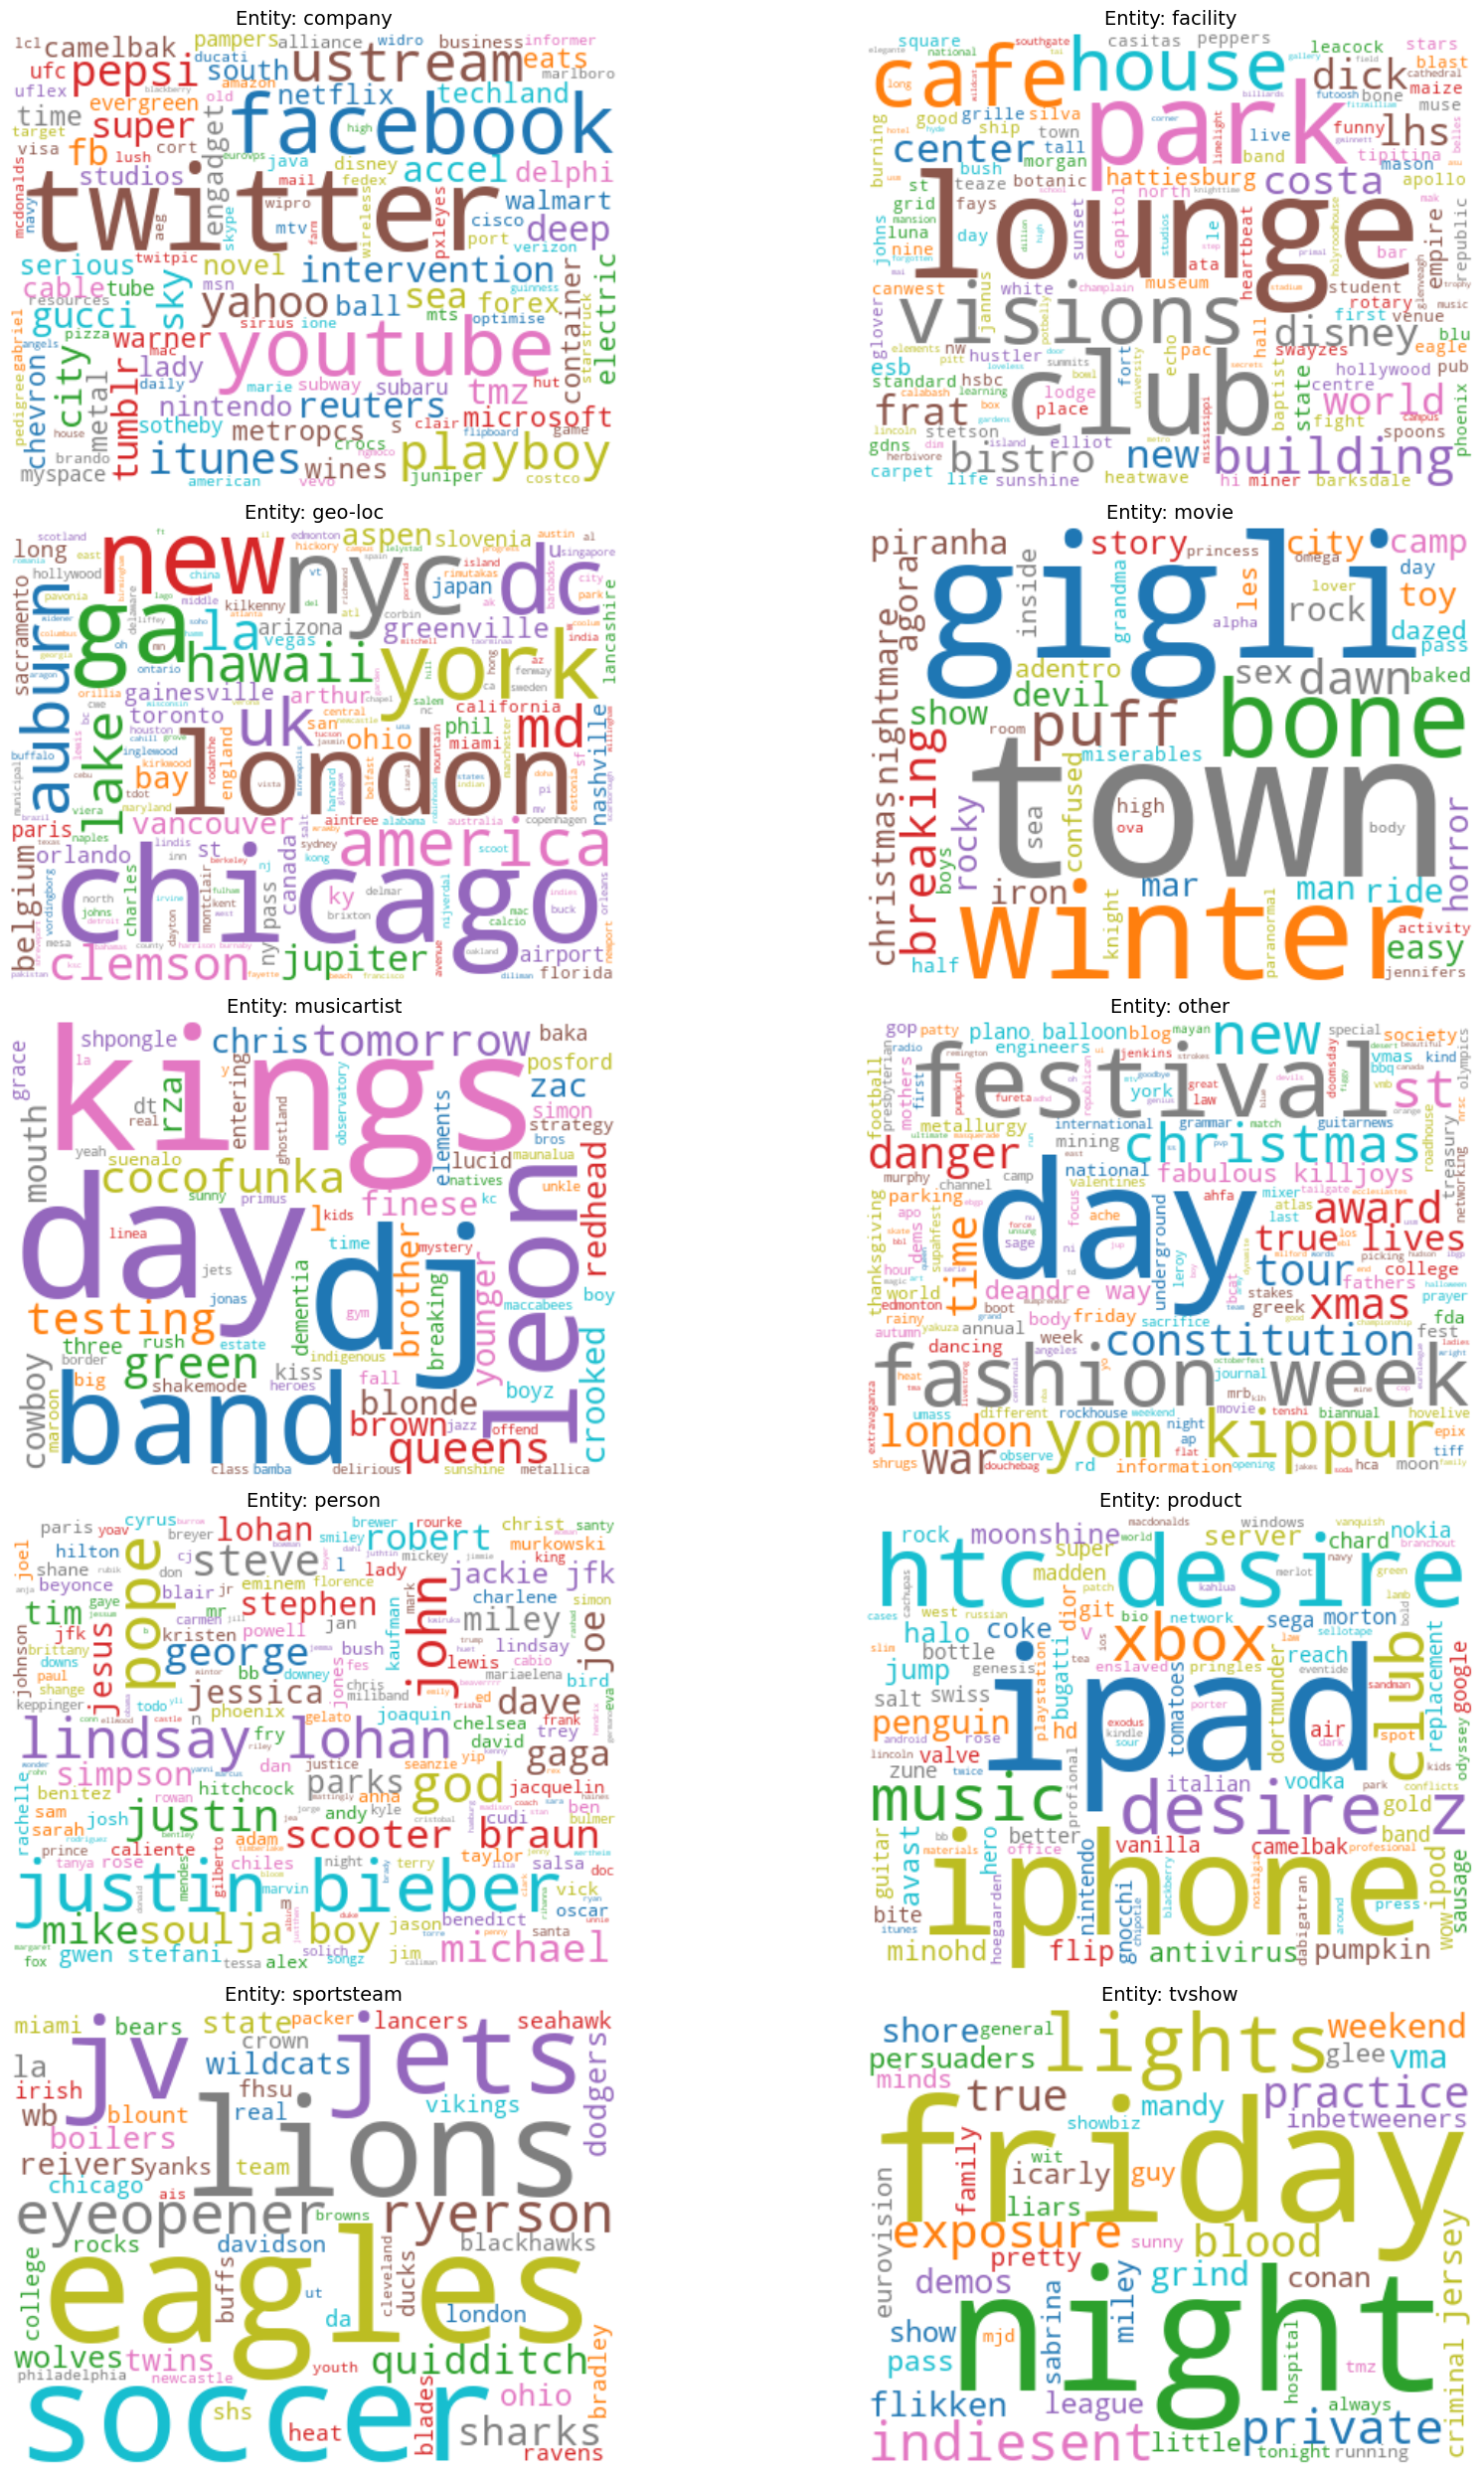

In [17]:
# Create word clouds for each entity type
num_entities = len(entity_tokens)
cols = 2
rows = (num_entities + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(cols * 10, rows * 5))

for i, (entity, words) in enumerate(entity_tokens.items(), start=1):
    text = ' '.join(words)
    wordcloud = WordCloud(width=400, height=300, background_color='white', colormap='tab10').generate(text)

    plt.subplot(rows, cols, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Entity: {entity}", fontsize=14)

plt.tight_layout()
plt.show()

🔍 Key Observations
1. Dominance of 'O' Tags
O: 44,007 tags out of total ≈ 46,440 tags (i.e., ~95% are non-entity tokens as seen in real world examples).

This is highly imbalanced, and such dominance can cause the model to bias toward predicting 'O' most of the time, hurting entity detection performance.

2. Imbalance Across Entity Classes
Some entity types have very few examples, e.g.:

B-movie: 34

B-tvshow: 34

B-musicartist: 55

B-sportsteam: 51

Others are more common:

B-person: 449

B-geo-loc: 276

B-company: 171

This imbalance can cause the model to:

Overfit frequent entity types (like person, geo-loc)

Underperform on rare entity types (like tvshow, movie)

3. Sentence Statistics
Number of sentences: 2,394

Sentence length:

Min: 1

Max: 39

Mean: 19.41

Median: 20

Most sentences are of moderate length, suggesting a decent context window for NER learning.